In [ ]:
### General imports
import re
import pandas as pd
import xarray as xr
import numpy as np

### Plots
import matplotlib.pyplot as plt
import seaborn as sns

### Stats
from scipy.integrate import quad
from scipy.special import erf

In [2]:
path = "/home/jmindlin/BF_codes/data/DCENT_GMST_statistics.txt"

# 1) Find the header line ("Year,GMST (°C),...")
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

start = next(i for i, line in enumerate(lines) if line.strip().startswith("Year,"))


# 2) Read CSV from that header line onward; allow commas with spaces
df = pd.read_csv(
    path,
    skiprows=start,               # start at the header line
    engine="python",
    sep=r"\s*,\s*",               # split on commas, ignoring surrounding spaces
    comment=None
)

# 3) Clean column names to something easy to use
rename_map = {
    "Year": "year",
    "GMST (°C)": "gmst",
    "1 s.d. (°C)": "gmst_sd",
    "GMST non infilled (°C)": "gmst_noninf",
    "1 s.d. (°C; non  infilled)": "gmst_noninf_sd",
}
# in case of double spaces etc., normalize header keys first
df.columns = [re.sub(r"\s+", " ", c).strip() for c in df.columns]
rename_map_norm = {re.sub(r"\s+", " ", k).strip(): v for k, v in rename_map.items()}
df = df.rename(columns=rename_map_norm)

# 4) Ensure numeric dtypes
for c in ["year", "gmst", "gmst_sd", "gmst_noninf", "gmst_noninf_sd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) Convert to xarray (optional)
ds = xr.Dataset(
    {
        "GMST": (["year"], df["gmst"].values),
        "GMST_sd": (["year"], df["gmst_sd"].values),
        "GMST_non_infilled": (["year"], df["gmst_noninf"].values),
        "GMST_non_infilled_sd": (["year"], df["gmst_noninf_sd"].values),
    },
    coords={"year": df["year"].values.astype(int)},
)
ds_full = ds.copy()
ds = ds - ds.sel(year=slice('1951','1980')).mean(dim='year')


In [3]:
# --- Load GISTEMP annual global mean anomalies (°C, 1951–1980 baseline) ---
t = ds.year
y = ds['GMST'].values
n = len(y)

# --- Linear model ---
X_lin = np.column_stack([np.ones(n), t])
beta_lin, *_ = np.linalg.lstsq(X_lin, y, rcond=None)
yhat_lin = X_lin @ beta_lin
resid_lin = y - yhat_lin

# --- Breakpoint model ---
def fit_break(t2):
    left = (t <= t2).astype(float)
    right = 1.0 - left
    X = np.column_stack([np.ones(n), (t - t2)*left, (t - t2)*right])
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    return X @ beta, beta

# Search break by SSE
cands = t[1:-1]
best = min(((np.sum((y - fit_break(t2)[0])**2), t2) for t2 in cands), key=lambda x: x[0])
t2_hat = best[1]
yhat_brk, beta_brk = fit_break(t2_hat)
resid_brk = y - yhat_brk


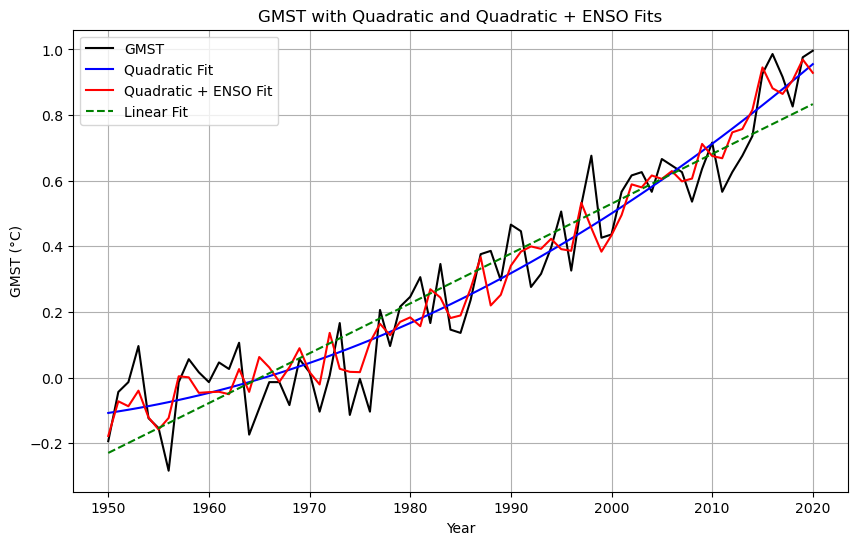

In [4]:

# --- Load GISTEMP annual global mean anomalies (°C, 1951–1980 baseline) ---
t = ds.sel(year=slice('1950','2020')).year
y = ds['GMST'].sel(year=slice('1950','2020')).values

### Linear model
X_lin = np.column_stack([np.ones(len(y)), t])
beta_lin, *_ = np.linalg.lstsq(X_lin, y, rcond=None)
yhat_lin = X_lin @ beta_lin
rss_lin = np.sum((y - yhat_lin)**2)

### Quadratic model
X_quad = np.column_stack([np.ones(len(y)), t, t**2])
beta_quad, *_ = np.linalg.lstsq(X_quad, y, rcond=None)
yhat_quad = X_quad @ beta_quad
rss_quad = np.sum((y - yhat_quad)**2)

oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    df = np.loadtxt(src,skiprows=1, max_rows=76)
    oni = np.concatenate([df[i,1:13].flatten() for i in range(df.shape[0]-1)])
    t = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(oni,dims=["time"],coords={"time": t}, name="oni",attrs={    "units": "degC",    "source": 'NOAA'})
    return da

oni = load_oni_xarray(oni_path)

# Select common period
oni_annual = oni.sel(time=slice('1950','2020')).groupby('time.year').mean(dim='time')

### Quadratic + ENSO model
X_quad_enso = np.column_stack([np.ones(len(y)), t, t**2, oni_annual.values])
beta_quad_enso, *_ = np.linalg.lstsq(X_quad_enso, y, rcond=None)
yhat_quad_enso = X_quad_enso @ beta_quad_enso
resid_quad_enso = y - yhat_quad_enso


plt.figure(figsize=(10,6))
plt.plot(t, y, label='GMST', color='black')
plt.plot(t, yhat_quad, label='Quadratic Fit', color='blue')
plt.plot(t, yhat_quad_enso, label='Quadratic + ENSO Fit', color='red')
plt.plot(t, yhat_lin, label='Linear Fit', color='green', linestyle='--')
plt.xlabel('Year')
plt.ylabel('GMST (°C)')
plt.title('GMST with Quadratic and Quadratic + ENSO Fits')
plt.legend()
plt.grid()
plt.show()


In [5]:

# --- Load GISTEMP annual global mean anomalies (°C, 1951–1980 baseline) ---
t = ds.sel(year=slice('1950','2024')).year
y = ds['GMST'].sel(year=slice('1950','2024')).values

### Linear model
X_lin = np.column_stack([np.ones(len(y)), t])
yhat_lin = X_lin @ beta_lin
rss_lin = np.sum((y - yhat_lin)**2)

### Quadratic model
X_quad = np.column_stack([np.ones(len(y)), t, t**2])
yhat_quad = X_quad @ beta_quad
rss_quad = np.sum((y - yhat_quad)**2)

oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    df = np.loadtxt(src,skiprows=1, max_rows=76)
    oni = np.concatenate([df[i,1:13].flatten() for i in range(df.shape[0]-1)])
    t = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(oni,dims=["time"],coords={"time": t}, name="oni",attrs={    "units": "degC",    "source": 'NOAA'})
    return da

oni = load_oni_xarray(oni_path)

# Select common period
oni_annual = oni.sel(time=slice('1950','2024')).groupby('time.year').mean(dim='time')

### Quadratic + ENSO model
X_quad_enso = np.column_stack([np.ones(len(y)), t, t**2, oni_annual.values])
yhat_quad_enso = X_quad_enso @ beta_quad_enso
resid_quad_enso = y - yhat_quad_enso


### RECORDS

In [6]:
# ------------------------------------------------------------------------------------
# 0. Helper functions (rep.row / rep.col equivalents if you ever need them)
# ------------------------------------------------------------------------------------

def rep_row(x, n):
    """Repeat 1D array x as n rows."""
    x = np.asarray(x)
    return np.tile(x, (n, 1))

def rep_col(x, n):
    """Repeat 1D array x as n columns."""
    x = np.asarray(x)
    return np.tile(x[:, None], (1, n))


# ------------------------------------------------------------------------------------
# 1. Gaussian distribution: record-breaking / record-shattering probabilities
# ------------------------------------------------------------------------------------

def p_Tt_f(TX, mu_all=0.0, sigma=1.0):
    """Gaussian pdf at TX with mean mu_all and std sigma."""
    TX = np.asarray(TX)
    return 1.0 / (np.sqrt(2.0 * np.pi * sigma**2)) * np.exp(-(TX - mu_all)**2 / (2.0 * sigma**2))


def f_xt_f(x, mu_all=0.0, sigma=1.0):
    """
    Helper CDF term used in the R code:

    0.5 - 0.5 * erf( (x - mu_all) / (sigma * sqrt(2)) )
    = 1 - Φ( (x - mu_all)/sigma )

    In the record calculation they use (1 - f_xt_f) = Φ(...) = P(X <= x).
    """
    return 0.5 - 0.5 * erf((x - mu_all) / (sigma * np.sqrt(2.0)))


def P_rec_inner_f(x, forced_trend, sigma, c=0.0):
    """
    Integrand used for analytical record probability for Gaussian case.
    forced_trend: array of means [mu_1, ..., mu_t]
    sigma: either scalar or array of length t
    c: record-shattering margin
    """
    forced_trend = np.asarray(forced_trend)
    t = len(forced_trend)

    if np.ndim(sigma) == 0:
        # single sigma for all times
        prod = p_Tt_f(TX=x + c, mu_all=forced_trend[-1], sigma=sigma)
        for i in range(t - 1):
            # all earlier time steps smaller than x
            prod *= (1.0 - f_xt_f(x=x, mu_all=forced_trend[i], sigma=sigma))
    else:
        sigma = np.asarray(sigma)
        assert len(sigma) == t
        prod = p_Tt_f(TX=x + c, mu_all=forced_trend[-1], sigma=sigma[-1])
        for i in range(t - 1):
            prod *= (1.0 - f_xt_f(x=x, mu_all=forced_trend[i], sigma=sigma[i]))

    return prod


def P_rec_f2(forced_trend, sigma, c=0.0, seq_ix=None,
             lower=-100.0, upper=100.0):
    """
    Analytical probability of record (Gaussian case).

    forced_trend: array of means [mu_1, ..., mu_t]
    sigma: scalar or array of same length as forced_trend
    c: record-shattering margin
    seq_ix: list/array of time indices (1-based, as in R) at which to evaluate P(record).
            e.g. np.arange(1, t+1)
    """
    forced_trend = np.asarray(forced_trend)
    t = len(forced_trend)
    if seq_ix is None:
        seq_ix = np.arange(1, t + 1)

    out = np.full(len(seq_ix), np.nan)

    if np.ndim(sigma) == 0:
        for k, idx in enumerate(seq_ix):
            idx = int(idx)
            mu_sub = forced_trend[:idx]
            val, _ = quad(P_rec_inner_f, lower, upper,
                          args=(mu_sub, sigma, c),
                          limit=int(1e5))
            out[k] = val
    else:
        sigma = np.asarray(sigma)
        assert len(sigma) == t
        for k, idx in enumerate(seq_ix):
            idx = int(idx)
            mu_sub = forced_trend[:idx]
            sig_sub = sigma[:idx]
            val, _ = quad(P_rec_inner_f, lower, upper,
                          args=(mu_sub, sig_sub, c),
                          limit=int(1e5))
            out[k] = val

    return out


def simulate_extremes_f(forced_trend, sigma, n_rep=10_000, c=0.0, AR_param=0.0):
    """
    Monte Carlo simulation of record-breaking / shattering extremes
    for Gaussian distributions with optional AR(1) structure.

    forced_trend: array of means [mu_1, ..., mu_t]
    sigma: scalar or array of length t
    n_rep: number of realizations
    c: record-shattering margin
    AR_param: AR(1) coefficient (0 for i.i.d.)
    """
    forced_trend = np.asarray(forced_trend)
    t = len(forced_trend)

    # --- simulate anomalies (no forced trend yet) ---
    if AR_param == 0:
        if np.ndim(sigma) == 0:
            # same sigma for all years
            test = np.random.normal(loc=0.0, scale=sigma, size=(t, n_rep))
        else:
            sigma = np.asarray(sigma)
            assert len(sigma) == t
            # standard normals then scale each row
            test = np.random.normal(loc=0.0, scale=1.0, size=(t, n_rep))
            test = test * sigma[:, None]
    else:
        # AR(1) with unit variance innovations scaled to desired variance
        sigma_AR = np.sqrt(1.0 - AR_param**2)
        test = np.zeros((t, n_rep))
        # start with 0, then iterate
        for j in range(n_rep):
            eps = np.random.normal(loc=0.0, scale=sigma_AR, size=t)
            for i in range(1, t):
                test[i, j] = AR_param * test[i - 1, j] + eps[i]

        if np.ndim(sigma) == 0:
            test *= sigma
        else:
            sigma = np.asarray(sigma)
            assert len(sigma) == t
            test = test * sigma[:, None]

    # add deterministic forced trend
    test_det = np.tile(forced_trend[:, None], (1, n_rep))
    test1 = test + test_det

    # time-evolving max for each realization (same off-by-one logic as the R code)
    max_mat = np.empty_like(test1)
    max_mat[0, :] = test1[0, :]
    for i in range(1, t):
        # max of previous max and previous value
        max_mat[i, :] = np.maximum(max_mat[i - 1, :], test1[i - 1, :])

    # Check whether current value exceeds (previous max + c)
    rec_extremes = (test1 > (max_mat + c)).mean(axis=1)  # rowMeans in R

    return rec_extremes


# ------------------------------------------------------------------------------------
# 2. GEV distribution: record-breaking / record-shattering probabilities
# ------------------------------------------------------------------------------------

def t_x(x, loc=0.0, scale=1.0, shape=0.0):
    """
    Helper function for GEV pdf/cdf.
    shape == 0 -> Gumbel limit.
    """
    x = np.asarray(x)
    if np.isclose(shape, 0.0):
        return np.exp(-(x - loc) / scale)
    else:
        return (1.0 + shape * (x - loc) / scale) ** (-1.0 / shape)


def p_Tt_GEV(x, loc=0.0, scale=1.0, shape=0.0):
    """GEV pdf at x."""
    tx = t_x(x, loc=loc, scale=scale, shape=shape)
    return 1.0 / scale * tx**(shape + 1.0) * np.exp(-tx)


def f_xt_GEV(x, loc=0.0, scale=1.0, shape=0.0):
    """GEV CDF at x."""
    tx = t_x(x, loc=loc, scale=scale, shape=shape)
    return np.exp(-tx)


def P_rec_inner_GEV(x, forced_trend, scale, c=0.0, shape=0.0):
    """
    Integrand for analytical record probability in GEV case.
    forced_trend: array of locations [loc_1, ..., loc_t]
    scale: scalar or array of length t
    c: record-shattering margin
    """
    forced_trend = np.asarray(forced_trend)
    t = len(forced_trend)

    if np.ndim(scale) == 0:
        # single scale
        prod = p_Tt_GEV(x + c, loc=forced_trend[-1], scale=scale, shape=shape)
        for i in range(t - 1):
            prod *= f_xt_GEV(x, loc=forced_trend[i], scale=scale, shape=shape)
    else:
        scale = np.asarray(scale)
        assert len(scale) == t
        prod = p_Tt_GEV(x + c, loc=forced_trend[-1], scale=scale[-1], shape=shape)
        for i in range(t - 1):
            prod *= f_xt_GEV(x, loc=forced_trend[i], scale=scale[i], shape=shape)

    return prod


def P_rec_GEV(forced_trend, c=0.0, scale=1.0, shape=0.0, seq_ix=None,
              lower=-5.0, upper=10.0):
    """
    Analytical probability of record (GEV case).

    forced_trend: array of GEV locations [loc_1, ..., loc_t]
    scale: scalar or array of same length as forced_trend
    shape: GEV shape parameter xi
    seq_ix: list/array of time indices (1-based, as in R) at which to evaluate.
    lower, upper: integration limits.
    """
    forced_trend = np.asarray(forced_trend)
    t = len(forced_trend)
    if seq_ix is None:
        seq_ix = np.arange(1, t + 1)

    out = np.full(len(seq_ix), np.nan)

    if np.ndim(scale) == 0:
        for k, idx in enumerate(seq_ix):
            idx = int(idx)
            loc_sub = forced_trend[:idx]
            val, _ = quad(P_rec_inner_GEV, lower, upper,
                          args=(loc_sub, scale, c, shape),
                          limit=int(1e7))
            out[k] = val
    else:
        scale = np.asarray(scale)
        assert len(scale) == t
        for k, idx in enumerate(seq_ix):
            idx = int(idx)
            loc_sub = forced_trend[:idx]
            scale_sub = scale[:idx]
            val, _ = quad(P_rec_inner_GEV, lower, upper,
                          args=(loc_sub, scale_sub, c, shape),
                          limit=int(1e7))
            out[k] = val

    return out


import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

def p_Tt_gauss(x, mu, sigma):
    """
    Gaussian pdf at x for N(mu, sigma^2).
    """
    return norm.pdf(x, loc=mu, scale=sigma)

def F_xt_gauss(x, mu, sigma):
    """
    Gaussian *upper* tail in the R code is 0.5 - 0.5*erf(...).
    But we actually need the *lower* tail CDF F(x) = P(X <= x),
    so we will just use norm.cdf directly.
    """
    return norm.cdf(x, loc=mu, scale=sigma)

def _P_rec_inner_gauss(x, mu_series, sigma_series, c=0.0):
    """
    Integrand for the record probability at the *last* time step in mu_series.
    This mirrors P_rec_inner_f in the R code.
    """
    mu_series = np.asarray(mu_series)
    sigma_series = np.asarray(sigma_series)

    # last time step t
    mu_t = mu_series[-1]
    sigma_t = sigma_series[-1]

    # previous time steps 1...(t-1)
    mu_prev = mu_series[:-1]
    sigma_prev = sigma_series[:-1]

    # pdf of X_t evaluated at x + c
    pdf_t = p_Tt_gauss(x + c, mu_t, sigma_t)

    # product over i < t of F_i(x) = P(X_i <= x)
    # do this in log-space for numerical stability
    log_F_prev = norm.logcdf(x, loc=mu_prev, scale=sigma_prev)
    log_prod_F_prev = np.sum(log_F_prev)
    prod_F_prev = np.exp(log_prod_F_prev)

    return pdf_t * prod_F_prev

def record_prob_gauss(forced_trend, sigma, c=0.0, idxs=None,
                      x_min=-20.0, x_max=20.0, **quad_kwargs):
    """
    Analytic probability of a record (or record-shattering if c>0)
    for a Gaussian process with time-dependent mean (forced_trend)
    and constant or time-dependent sigma.

    forced_trend : array-like of length T of mu_t
    sigma        : scalar or array-like of same length as forced_trend
    c            : record-shattering margin (in same units as X)
    idxs         : indices t at which to evaluate P(record at t)
                   (if None, uses 1..T-1)
    returns      : array of probabilities of same length as idxs
    """
    mu = np.asarray(forced_trend)
    T = len(mu)

    # allow sigma either scalar or array
    if np.isscalar(sigma):
        sigma_arr = np.full(T, float(sigma))
    else:
        sigma_arr = np.asarray(sigma)
        if sigma_arr.shape != mu.shape:
            raise ValueError("sigma must be scalar or same shape as forced_trend")

    if idxs is None:
        idxs = np.arange(1, T)  # record probs from 2nd year onward (0-based)

    probs = np.zeros(len(idxs))

    for j, t_idx in enumerate(idxs):
        mu_slice = mu[:t_idx+1]
        sigma_slice = sigma_arr[:t_idx+1]

        integrand = lambda x: _P_rec_inner_gauss(x, mu_slice, sigma_slice, c=c)

        val, err = quad(integrand, x_min, x_max,
                        epsrel=1e-6, limit=200, **quad_kwargs)
        probs[j] = val

    return probs


In [7]:
def record_and_exceed_prob_gauss(forced_trend, sigma, t_idx, y_obs,
                                 c=0.0, x_max=20.0, **quad_kwargs):
    """
    P(record in year t_idx AND X_t >= y_obs) analytically, Gaussian case.
    forced_trend : mu_t array
    sigma        : scalar or array
    t_idx        : index of target year (0-based)
    y_obs        : observed value in that year (same units as X)
    c            : record-shattering margin
    """
    mu = np.asarray(forced_trend)
    T = len(mu)

    if np.isscalar(sigma):
        sigma_arr = np.full(T, float(sigma))
    else:
        sigma_arr = np.asarray(sigma)
        if sigma_arr.shape != mu.shape:
            raise ValueError("sigma must be scalar or same shape as forced_trend")

    mu_slice = mu[:t_idx+1]
    sigma_slice = sigma_arr[:t_idx+1]

    lower = y_obs - c  # see explanation above

    integrand = lambda x: _P_rec_inner_gauss(x, mu_slice, sigma_slice, c=c)
    val, err = quad(integrand, lower, x_max, epsrel=1e-6, limit=200, **quad_kwargs)
    return val


In [8]:
k_enso = X_quad_enso.shape[1]
sigma_hat = np.sqrt(np.sum(resid_quad_enso**2) / (len(y) - k_enso))
print("Estimated sigma:", sigma_hat)

Estimated sigma: 0.09019414366582582


In [9]:
years_all = ds['year'].sel(year=slice('1950','2024')).values

# Prepare design matrices for all years (not only the fit period)
X_lin_all = np.column_stack([np.ones(len(years_all)), years_all])
mu_lin = X_lin_all @ beta_lin

X_quad_all = np.column_stack([np.ones(len(years_all)), years_all, years_all**2])
mu_quad = X_quad_all @ beta_quad

# ONI annual up to 2024
oni_annual_all = oni.sel(time=slice('1950','2024')).groupby('time.year').mean(dim='time').sel(year=years_all).values
X_quad_enso_all = np.column_stack([np.ones(len(years_all)), years_all, years_all**2, oni_annual_all])
mu_quad_enso = X_quad_enso_all @ beta_quad_enso


In [10]:
# indices for years >= 1980 (0-based)
idx_1980_on = np.where(years_all >= 1980)[0]

p_rec_lin  = record_prob_gauss(mu_lin,        sigma_hat, c=0.0, idxs=idx_1980_on)
p_rec_quad = record_prob_gauss(mu_quad,       sigma_hat, c=0.0, idxs=idx_1980_on)
p_rec_qe   = record_prob_gauss(mu_quad_enso,  sigma_hat, c=0.0, idxs=idx_1980_on)

years_1980_on = years_all[idx_1980_on]


In [11]:
y_obs_2023 = ds['GMST'].sel(year=2023).item()
print("Observed GMST anomaly 2023:", y_obs_2023)


Observed GMST anomaly 2023: 1.186


In [12]:
t_idx_2023 = np.where(years_all == 2023)[0][0]


In [13]:
p_rec_2023_lin  = p_rec_lin[years_1980_on == 2023][0]
p_rec_2023_quad = p_rec_quad[years_1980_on == 2023][0]
p_rec_2023_qe   = p_rec_qe[years_1980_on == 2023][0]

p_rec_and_obs_lin  = record_and_exceed_prob_gauss(mu_lin,       sigma_hat, t_idx_2023, y_obs_2023, c=0.0)
p_rec_and_obs_quad = record_and_exceed_prob_gauss(mu_quad,      sigma_hat, t_idx_2023, y_obs_2023, c=0.0)
p_rec_and_obs_qe   = record_and_exceed_prob_gauss(mu_quad_enso, sigma_hat, t_idx_2023, y_obs_2023, c=0.0)

print("Unconditional P(record in 2024):")
print("  Linear:          ", p_rec_2023_lin)
print("  Quadratic:       ", p_rec_2023_quad)
print("  Quadratic+ENSO:  ", p_rec_2023_qe)

print("\nP(record in 2024 AND GMST_2024 >= observed):")
print("  Linear:          ", p_rec_and_obs_lin)
print("  Quadratic:       ", p_rec_and_obs_quad)
print("  Quadratic+ENSO:  ", p_rec_and_obs_qe)


Unconditional P(record in 2024):
  Linear:           0.2467824903455528
  Quadratic:        0.3595462660318012
  Quadratic+ENSO:   0.6581760624367611

P(record in 2024 AND GMST_2024 >= observed):
  Linear:           0.00033054391316654556
  Quadratic:        0.04488988211912147
  Quadratic+ENSO:   0.16752170889115178


In [14]:
# --- Add a constant “stationary climate” hypothesis -------------------------
# Here we assume:
# - GMST anomalies y are already relative to a 1951–1980 baseline (so mean ≈ 0)
# - Stationary climate => constant mean μ(t) = 0 for all years
# - Constant σ estimated from the full period (or a chosen baseline)

# 1) Define stationary mean and sigma
mask_2023 = (t <= 2023)              # make sure t includes 2023
t_2023 = t[mask_2023]
y_2023 = y[mask_2023]

mu_stationary = np.zeros_like(t_2023, dtype=float)
sigma_stationary = np.std(y_2023, ddof=1)

# 2) Compute analytical record-breaking probabilities under stationarity
#    using the previously translated Gaussian function P_rec_f2
seq_ix_2023 = np.arange(1, len(t_2023) + 1)   # 1..N (to mirror R's 1-based seq.ix)
p_stat = P_rec_f2(
    forced_trend=mu_stationary,
    sigma=sigma_stationary,
    c=0.0,
    seq_ix=seq_ix_2023
)

# 3) Extract probability of a record in 2023 under the stationary hypothesis
p_stationary_2023 = p_stat[-1]

In [15]:
BF_lin_vs_quad  =  p_rec_2023_quad / p_rec_2023_lin
BF_lin_vs_qe   = p_rec_2023_qe / p_rec_2023_lin
BF_stationary_vs_quad  =  p_rec_2023_quad / p_stationary_2023
BF_stationary_vs_qe   = p_rec_2023_qe / p_stationary_2023
BF_stationary_vs_lin = p_rec_2023_lin / p_stationary_2023


In [18]:
def plot_record_analysis(
    t, y,
    record_flags, record_magnitudes,
    p_stat, p_lin, p_quad, p_quad_enso,
    year_min=1980, year_max=2024
):
    """
    Make the 3-panel figure:
    (a) Observed records and magnitudes
    (b) Record probabilities under each model
    (c) Bayes Factors vs stationary climate
    """

    # --- Restrict to 1980-2024 ---
    mask = (t >= year_min) & (t <= year_max)
    t_sub   = t[mask]
    y_sub   = y[mask]
    rec_sub = record_flags[mask]
    mag_sub = record_magnitudes[mask]

    p_stat_sub      = p_stat[mask]
    p_lin_sub       = p_lin[mask]
    p_quad_sub      = p_quad[mask]
    p_quad_enso_sub = p_quad_enso[mask]

    # === Bayes Factors vs stationary ===
    # Use only years where a record occurred
    rec_years = np.where(rec_sub)[0]
    if len(rec_years) == 0:
        raise ValueError("No records between 1980–2024.")

    # Likelihood ratio per model vs stationary
    def likelihood_ratio(p_model, p_stat):
        L_model = np.prod(p_model[rec_years])
        L_stat  = np.prod(p_stat[rec_years])
        return L_model / L_stat

    BF_lin  = likelihood_ratio(p_lin_sub, p_stat_sub)
    BF_quad = likelihood_ratio(p_quad_sub, p_stat_sub)
    BF_qe   = likelihood_ratio(p_quad_enso_sub, p_stat_sub)

    # === Colors (simple) ===
    colors = {
        "obs": "black",
        "record": "red",
        "stat": "gray",
        "lin": "purple",
        "quad": "orange",
        "qe": "green"
    }

    # === Make figure ===
    fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=150)

    # --------------------------------------------------------------
    # (a) Observations + records + record magnitudes
    # --------------------------------------------------------------
    axs[0].plot(t_sub, y_sub, color=colors["obs"], label="GMST")
    axs[0].scatter(t_sub[rec_sub], y_sub[rec_sub], color=colors["record"], label="Records")

    # add the magnitude bars
    for ti, yi, mi in zip(t_sub[rec_sub], y_sub[rec_sub], mag_sub[rec_sub]):
        axs[0].vlines(ti, yi - mi, yi, color="red", linewidth=2)

    axs[0].set_title("(a) Observed records", fontsize=14)
    axs[0].set_ylabel("GMST anomaly (°C)")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # bar plot below curve
    axs[0].bar(
        t_sub[record_flags],
        record_magnitudes[record_flags],
        width=0.6,
        color="red",
        alpha=0.5,
        label="Record magnitude"
    )
    # --------------------------------------------------------------
    # (b) Probabilities of record
    # --------------------------------------------------------------
    axs[1].plot(t_sub, p_stat_sub,      color=colors["stat"], label="Stationary")
    axs[1].plot(t_sub, p_lin_sub,       color=colors["lin"],  label="Linear")
    axs[1].plot(t_sub, p_quad_sub,      color=colors["quad"], label="Quadratic")
    axs[1].plot(t_sub, p_quad_enso_sub, color=colors["qe"],   label="Quadratic+ENSO")

    axs[1].set_title("(b) P(record at year)", fontsize=14)
    axs[1].set_ylabel("Probability")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    # --------------------------------------------------------------
    # (c) Bayes Factors vs stationary
    # --------------------------------------------------------------
    models = ["Linear", "Quadratic", "Quad+ENSO"]
    BFs    = [BF_lin, BF_quad, BF_qe]
    axs[2].bar(models, BFs, color=[colors["lin"], colors["quad"], colors["qe"]])

    axs[2].set_title("(c) Bayes Factors vs stationary", fontsize=14)
    axs[2].set_ylabel("BF = P(D|model) / P(D|stationary)")
    axs[2].grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


In [16]:
def compute_records_and_magnitudes(series, years):
    """
    Inputs:
        series : 1D array (e.g., GMST anomalies)
        years  : matching years
    
    Returns:
        record_flags      : True where a new record occurs
        record_magnitudes: value - previous max (0 for first value)
        record_values     : actual values at record years
        record_years      : years where record happens
    """
    series = np.asarray(series)
    n = len(series)
    
    record_flags = np.zeros(n, dtype=bool)
    record_magnitudes = np.zeros(n)
    
    # First year is always a record
    record_flags[0] = True
    record_magnitudes[0] = np.nan   # no magnitude for first year
    
    max_so_far = series[0]
    
    for i in range(1, n):
        if series[i] > max_so_far:
            record_flags[i] = True
            record_magnitudes[i] = series[i] - max_so_far
            max_so_far = series[i]
        else:
            record_flags[i] = False
            record_magnitudes[i] = 0.0

    return (record_flags,
            record_magnitudes,
            series[record_flags],
            years[record_flags])


In [17]:
mask_1980_2024 = (ds.year >= 1980) & (ds.year <= 2024)
y_sub = ds["GMST"].values[mask_1980_2024]
t_sub = ds.year.values[mask_1980_2024]

(record_flags,
 record_magnitudes,
 record_values,
 record_years) = compute_records_and_magnitudes(y_sub, t_sub)


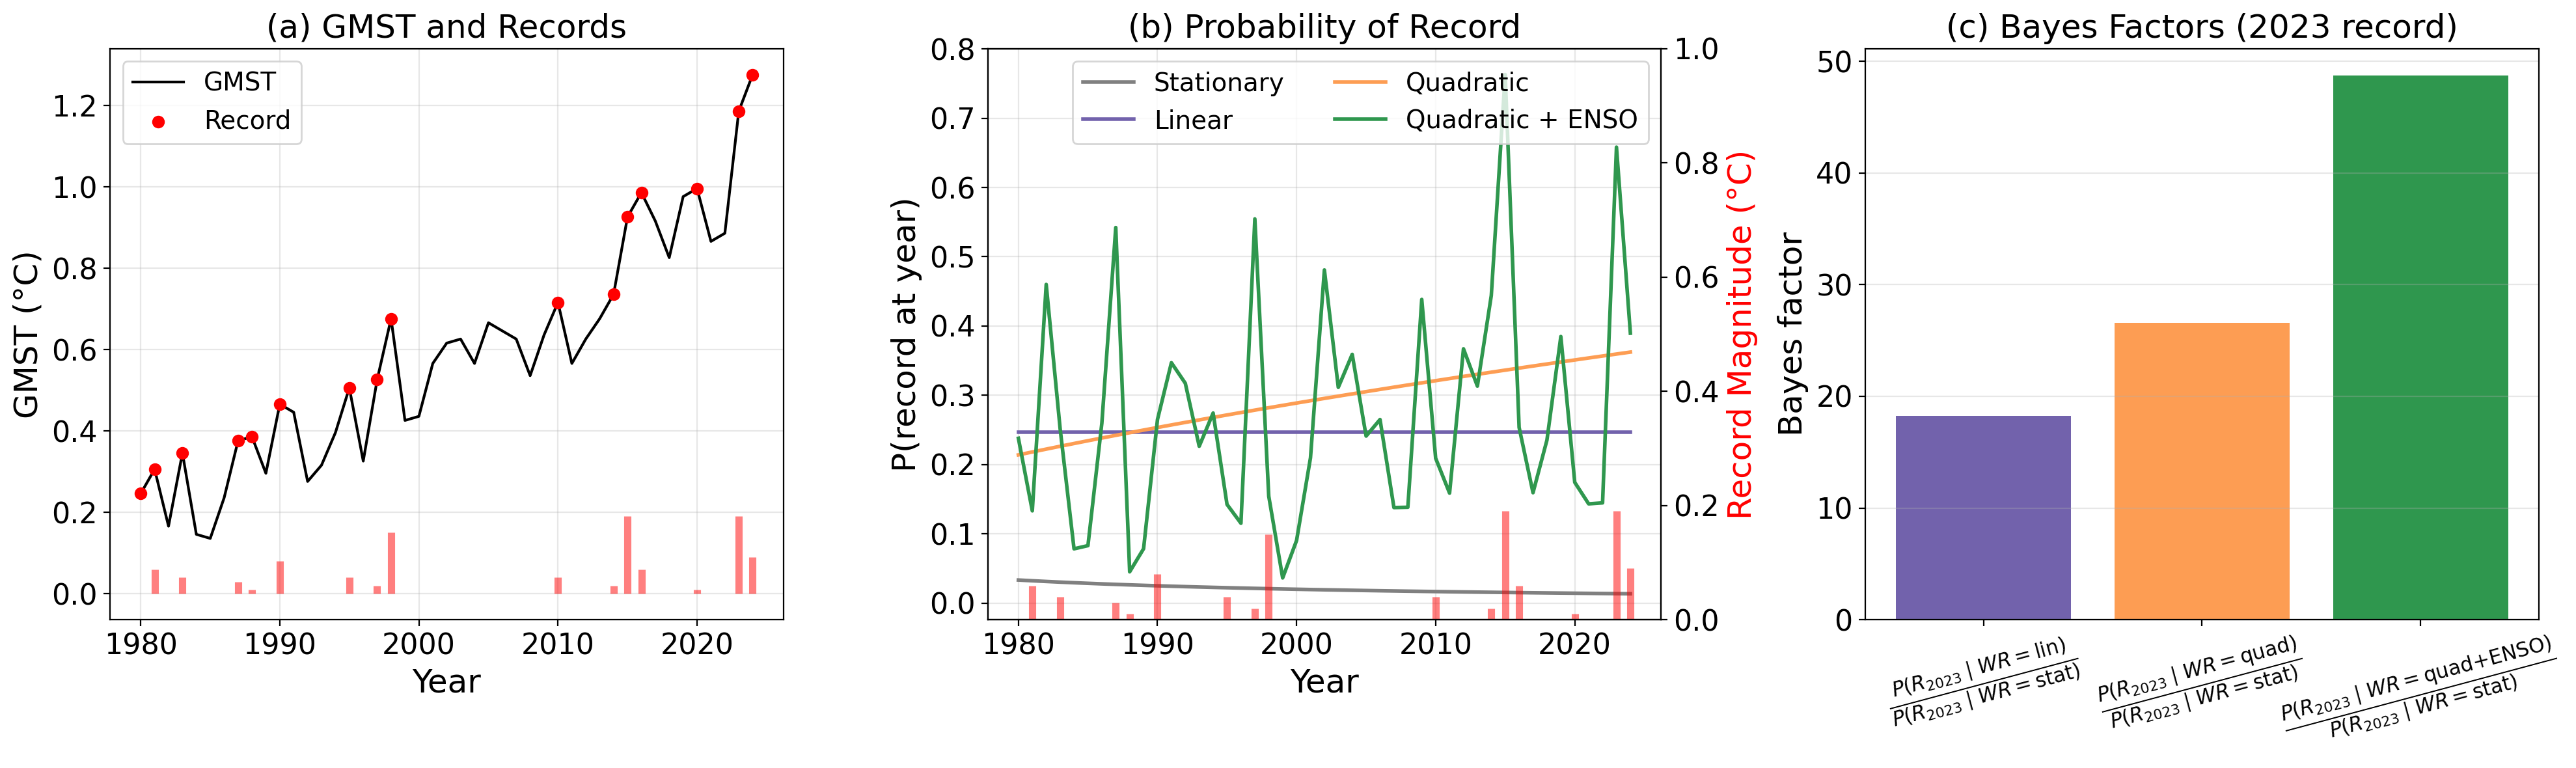

In [18]:
# === Font scaling ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 18
TICK_FONTSIZE  = 16
LEGEND_FONTSIZE = 14
ANNOT_FONTSIZE  = 14

# === Color setup ===
dark_oranges = sns.color_palette("Oranges", n_colors=15)[4:]
dark_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens  = sns.color_palette("Greens",  n_colors=9)[4:]

COLORS = {
    "Stationary": "gray",
    "Linear": dark_purples[2],
    "Quadratic": dark_oranges[2],
    "Quadratic + ENSO": dark_greens[2],
    "GMST": "black",
    "Record": "red"
}

def plot_records_and_bayes(
    t, y,
    p_stat, p_rec_lin, p_rec_quad, p_rec_qe,
    BF_lin_vs_quad, BF_quad_vs_qe, BF_stationary_vs_lin,
    start_year=1980, end_year=2024
):
    """Make 3-panel figure:
       (a) GMST + records + record magnitudes
       (b) Probability of record per year (all hypotheses)
       (c) Bayes factors at 2023.
    """

    t = np.asarray(t)
    y = np.asarray(y)
    p_stat      = np.asarray(p_stat)
    p_rec_lin   = np.asarray(p_rec_lin)
    p_rec_quad  = np.asarray(p_rec_quad)
    p_rec_qe    = np.asarray(p_rec_qe)

    # --- Time window mask ---
    mask = (t >= start_year) & (t <= end_year)

    t_sub = t[mask]
    y_sub = y[mask]

    p_stat_sub     = p_stat[mask]
    p_lin_sub      = p_rec_lin[mask]
    p_quad_sub     = p_rec_quad[mask]
    p_qe_sub       = p_rec_qe[mask]

    # --- Record flags over full series ---
    # rec_full[i] = True if y[i] > max(y[:i])
    rec_full = np.zeros_like(y, dtype=bool)
    rec_full[0] = True
    rec_full[1:] = y[1:] > np.maximum.accumulate(y[:-1])

    rec_sub = rec_full[mask]

    # --- Previous max and record magnitudes (full series, then restricted) ---
    prev_max = np.empty_like(y)
    prev_max[0] = np.nan
    prev_max[1:] = np.maximum.accumulate(y[:-1])

    prev_max_sub = prev_max[mask]
    rec_mag_sub = y_sub - prev_max_sub  # magnitude above previous record
    rec_mag_sub[~rec_sub] = np.nan      # only meaningful for record years

    # === Figure ===
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=200)

    # ---------------------------------------------------------
    # (a) GMST with records + record magnitudes
    # ---------------------------------------------------------
    ax = axs[0]
    ax.plot(t_sub, y_sub, label="GMST", color=COLORS["GMST"])

    # Mark record years
    ax.scatter(
        t_sub[rec_sub],
        y_sub[rec_sub],
        color=COLORS["Record"],
        label="Record",
        zorder=5
    )

    # Vertical bars for record magnitudes (from previous max to record)
    # Only where we have previous max (skip first value if NaN)
    for year, y_val, y_prev, is_rec in zip(t_sub,  y_sub,prev_max_sub, rec_sub):
        if is_rec and not np.isnan(y_prev):
            ax.vlines(
                year,
                y_prev*0,
                (y_val - y_prev),
                color=COLORS["Record"],
                alpha=0.5,
                linewidth=4
            )

    ax.set_title("(a) GMST and Records", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("GMST (°C)", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)
    ax.legend(fontsize=LEGEND_FONTSIZE)
    ax.grid(alpha=0.3)

    # ---------------------------------------------------------
    # (b) Record probability time series, all hypotheses
    # ---------------------------------------------------------
    ax = axs[1]
    ax.plot(t_sub, p_stat_sub,     label="Stationary",      color=COLORS["Stationary"], linestyle="-", linewidth=2)
    ax.plot(t_sub, p_lin_sub,      label="Linear",          color=COLORS["Linear"],     linestyle="-", linewidth=2)
    ax.plot(t_sub, p_quad_sub,     label="Quadratic",       color=COLORS["Quadratic"],  linestyle="-", linewidth=2)
    ax.plot(t_sub, p_qe_sub,       label="Quadratic + ENSO",color=COLORS["Quadratic + ENSO"], linestyle="-", linewidth=2)

    ax.set_title("(b) Probability of Record", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("P(record at year)", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)
    ax.legend(fontsize=LEGEND_FONTSIZE, ncol=2)
    ax.grid(alpha=0.3)
    
    ### Add y axis on the right for record magnitudes
    ax = ax.twinx()
    ax.set_ylabel("Record Magnitude (°C)", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)
    ax.set_ylim(ax.get_ylim())  # match y-limits
    ax.yaxis.label.set_color(COLORS["Record"])

    for year, y_val, y_prev, is_rec in zip(t_sub,  y_sub,prev_max_sub, rec_sub):
        if is_rec and not np.isnan(y_prev):
            ax.vlines(
                year,
                y_prev*0,
                (y_val - y_prev),
                color=COLORS["Record"],
                alpha=0.5,
                linewidth=4
            )

    # ---------------------------------------------------------
    # (c) Bayes factors at 2023
    # ---------------------------------------------------------
    ax = axs[2]

    labels = [
        r"$\frac{P(R_{2023}\mid WR=\text{lin})}{P(R_{2023}\mid WR=\text{stat})}$",
        r"$\frac{P(R_{2023}\mid WR=\text{quad})}{P(R_{2023}\mid WR=\text{stat})}$",
        r"$\frac{P(R_{2023}\mid WR=\text{quad+ENSO})}{P(R_{2023}\mid WR=\text{stat})}$"
    ]
    BF_values = [
        BF_stationary_vs_lin,
        BF_stationary_vs_quad,
        BF_stationary_vs_qe
    ]


    colors = [
        COLORS["Linear"],
        COLORS["Quadratic"],
        COLORS["Quadratic + ENSO"],  # re-use Linear color vs Stationary
    ]

    ax.bar(labels, BF_values, color=colors)
    ax.set_title("(c) Bayes Factors (2023 record)", fontsize=TITLE_FONTSIZE)
    ax.set_ylabel("Bayes factor", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE, rotation=15)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)
    ax.grid(axis="y", alpha=0.3)

    # Optionally show log-scale if factors are large:
    # ax.set_yscale("log")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Call with your precomputed arrays and Bayes factors:
# ------------------------------------------------------------------
plot_records_and_bayes(
    t[-45:], y[-45:],
    p_stat[-45:], p_rec_lin, p_rec_quad, p_rec_qe,
    BF_lin_vs_quad, BF_lin_vs_qe, BF_stationary_vs_lin,
    start_year=1980, end_year=2024
)


In [ ]:

# === Font scaling ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 18
TICK_FONTSIZE  = 16
LEGEND_FONTSIZE = 14
ANNOT_FONTSIZE  = 14

# === Color setup ===
dark_oranges = sns.color_palette("Oranges", n_colors=15)[4:]
dark_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens  = sns.color_palette("Greens",  n_colors=9)[4:]

COLORS = {
    "Stationary": "gray",
    "Linear": dark_purples[2],
    "Quadratic": dark_oranges[2],
    "Quadratic + ENSO": dark_greens[2],
    "GMST": "black",
    "Record": "red"
}

def plot_records_and_bayes(
    t, y,
    p_stat, p_rec_lin, p_rec_quad, p_rec_qe,
    BF_lin_vs_quad, BF_quad_vs_qe, BF_stationary_vs_lin,
    start_year=1980, end_year=2024
):
    """Make 3-panel figure:
       (a) GMST + records + record magnitudes
       (b) Probability of record per year (all hypotheses)
       (c) Bayes factors at 2023.
    """

    t = np.asarray(t)
    y = np.asarray(y)
    p_stat      = np.asarray(p_stat)
    p_rec_lin   = np.asarray(p_rec_lin)
    p_rec_quad  = np.asarray(p_rec_quad)
    p_rec_qe    = np.asarray(p_rec_qe)

    # --- Time window mask ---
    mask = (t >= start_year) & (t <= end_year)

    t_sub = t[mask]
    y_sub = y[mask]

    p_stat_sub     = p_stat[mask]
    p_lin_sub      = p_rec_lin[mask]
    p_quad_sub     = p_rec_quad[mask]
    p_qe_sub       = p_rec_qe[mask]

    # --- Record flags over full series ---
    # rec_full[i] = True if y[i] > max(y[:i])
    rec_full = np.zeros_like(y, dtype=bool)
    rec_full[0] = True
    rec_full[1:] = y[1:] > np.maximum.accumulate(y[:-1])

    rec_sub = rec_full[mask]

    # --- Previous max and record magnitudes (full series, then restricted) ---
    prev_max = np.empty_like(y)
    prev_max[0] = np.nan
    prev_max[1:] = np.maximum.accumulate(y[:-1])

    prev_max_sub = prev_max[mask]
    rec_mag_sub = y_sub - prev_max_sub  # magnitude above previous record
    rec_mag_sub[~rec_sub] = np.nan      # only meaningful for record years

    # === Figure ===
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=200)

    # ---------------------------------------------------------
    # (a) GMST with records + record magnitudes
    # ---------------------------------------------------------
    ax = axs[0]
    ax.plot(t_sub, y_sub, label="GMST", color=COLORS["GMST"])

    # Mark record years
    ax.scatter(
        t_sub[rec_sub],
        y_sub[rec_sub],
        color=COLORS["Record"],
        label="Record",
        zorder=5
    )

    # Vertical bars for record magnitudes (from previous max to record)
    # Only where we have previous max (skip first value if NaN)
    for year, y_val, y_prev, is_rec in zip(t_sub,  y_sub,prev_max_sub, rec_sub):
        if is_rec and not np.isnan(y_prev):
            ax.vlines(
                year,
                y_prev*0,
                (y_val - y_prev),
                color=COLORS["Record"],
                alpha=0.5,
                linewidth=4
            )

    ax.set_title("(a) GMST and Records", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("GMST (°C)", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)
    ax.legend(fontsize=LEGEND_FONTSIZE)
    ax.grid(alpha=0.3)

    # ---------------------------------------------------------
    # (b) Record probability time series, all hypotheses
    # ---------------------------------------------------------
    ax = axs[1]
    ax.plot(t_sub, p_stat_sub,     label="Stationary",      color=COLORS["Stationary"], linestyle="-", linewidth=2)
    ax.plot(t_sub, p_lin_sub,      label="Linear",          color=COLORS["Linear"],     linestyle="-", linewidth=2)
    ax.plot(t_sub, p_quad_sub,     label="Quadratic",       color=COLORS["Quadratic"],  linestyle="-", linewidth=2)
    ax.plot(t_sub, p_qe_sub,       label="Quadratic + ENSO",color=COLORS["Quadratic + ENSO"], linestyle="-", linewidth=2)

    ax.set_title("(b) Probability of Record", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("P(record at year)", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)
    ax.legend(fontsize=LEGEND_FONTSIZE, ncol=2)
    ax.grid(alpha=0.3)
    
    ### Add y axis on the right for record magnitudes
    ax = ax.twinx()
    ax.set_ylabel("Record Magnitude (°C)", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)
    ax.set_ylim(ax.get_ylim())  # match y-limits
    ax.yaxis.label.set_color(COLORS["Record"])

    for year, y_val, y_prev, is_rec in zip(t_sub,  y_sub,prev_max_sub, rec_sub):
        if is_rec and not np.isnan(y_prev):
            ax.vlines(
                year,
                y_prev*0,
                (y_val - y_prev),
                color=COLORS["Record"],
                alpha=0.5,
                linewidth=4
            )

    # ---------------------------------------------------------
    # (c) Bayes factors at 2023
    # ---------------------------------------------------------
    ax = axs[2]

    labels = [
        r"$\frac{P(R_{2023}\mid WR=\text{lin})}{P(R_{2023}\mid WR=\text{stat})}$",
        r"$\frac{P(R_{2023}\mid WR=\text{quad})}{P(R_{2023}\mid WR=\text{stat})}$",
        r"$\frac{P(R_{2023}\mid WR=\text{quad+ENSO})}{P(R_{2023}\mid WR=\text{stat})}$"
    ]
    BF_values = [
        BF_stationary_vs_lin,
        BF_stationary_vs_quad,
        BF_stationary_vs_qe
    ]


    colors = [
        COLORS["Linear"],
        COLORS["Quadratic"],
        COLORS["Quadratic + ENSO"],  # re-use Linear color vs Stationary
    ]

    ax.bar(labels, BF_values, color=colors)
    ax.set_title("(c) Bayes Factors (2023 record)", fontsize=TITLE_FONTSIZE)
    ax.set_ylabel("Bayes factor", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE, rotation=15)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)
    ax.grid(axis="y", alpha=0.3)

    # Optionally show log-scale if factors are large:
    # ax.set_yscale("log")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Call with your precomputed arrays and Bayes factors:
# ------------------------------------------------------------------
plot_records_and_bayes(
    t[-45:], y[-45:],
    p_stat[-45:], p_rec_lin, p_rec_quad, p_rec_qe,
    BF_lin_vs_quad, BF_lin_vs_qe, BF_stationary_vs_lin,
    start_year=1980, end_year=2024
)
